# TCLAB CLP PID FF

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from datetime import datetime
import tclab
import time

import os

import package_DBR
from package_DBR import myRound
from package_LAB import *
from package_DBR import *

import package_LAB
from package_LAB import *

## Parameters

In [2]:
t = []
SP = []

#MV = []
MV = {"MV" : [], "MVp" : [], "MVi": [],  "MVd": [], "E" : []}

DV = []
PV = []

#Man_Mode = []
MV_Man = []

#FF_Enable = []
ActivateFF = True

Exp = True
SlopePV = 0


TSim = 720
Ts = 1.0
N = int(TSim/Ts)+1


MV0 = 50
DV0 = 50
PV0 = 75


# Parameters for input-output dynamics
Kp = 0.57
T1p = 172.4
T2p = 2.8
Thetap = 2.0

# G & H, voir A

# Parameters for disturbance dynamics
Kd = 0.29
T1d = 127.9
T2d = 21.8
Thetad = 12.4

Man = []
MVMan = []
MVFF = []
MVFFDelay = []
MVFFLL1 = []

# Paths
SPPath = {0: 75, 800: 65}
DVPath = {0: DV0, 1500: DV0+5}
manPath = {0: True, 750 : False, TSim: False}
manMVPath = {0: MV0, TSim: MV0}



alpha = 0.5
gamma = 0.4
Tc = gamma * T1p
Kc, Ti, Td = IMC_Tuning(Kp, Thetap, Tc, T1p, T2p)
discretisation = ["TRAP", "TRAP"]


## Function used for interaction with TCLAB

In [3]:
def experiment(MV0,DV0,Ts):	
    global reg, t, MV, SP, PV, DV, Man_Mode

    def set_tclab_value(MV_value, DV_value):
        lab.Q1(MV_value)
        lab.Q2(DV_value)

    for i in range(0, N):
        t.append(i*Ts)

        
        """
        ## Create the path
        SelectPath_RT(SP_Path, t, SP)
        SelectPath_RT(DV_Path, t, DV)
        SelectPath_RT(Man_Mode_Path, t, Man_Mode)
        SelectPath_RT(MV_Man_Path, t, MV_Man)
        SelectPath_RT(FF_Enable_Path, t, FF_Enable)
        """

        # Input signal SP and DV
        SelectPath_RT(SPPath,t,SP)
        SelectPath_RT(DVPath,t,DV)

        # FeedForward
        Delay_RT(DV-DV0*np.ones_like(DV), np.max([Thetad-Thetap,0]),Ts,MVFFDelay)
        LeadLag_RT(MVFFDelay,-Kd/Kp, T1d, T1p, Ts, MVFFLL1)
        if ActivateFF:
            LeadLag_RT(MVFFLL1, 1, T2d, T2p, Ts, MVFF)
        else:
            #LeadLag_RT(MVFFLL1, 0, T2d, T2p, Ts, MVFF)
            MVFF.append(0)
        
        # PID controller mode
        SelectPath_RT(manPath,t,Man)
        SelectPath_RT(manMVPath, t, MVMan)
        
        # PID controller
        PID_RT(PV, SP[i], MV, Ts, Kc, Ti, Td, alpha, discretisation, PVinit=PV0, man=Man[i], manMV=MVMan, FF_MV=MVFF)
        # Process Dynamics
        lab.Q1(MV["MV"][-1])


        # Disturbance dynamics$
        DV - DV0*np.ones_like(DV)
        lab.Q2(DV[-1])
            

        PV.append(lab.T1)
        l1.set_data(t, MV["MV"])
        l2.set_data(t, PV)
        l3.set_data(t, DV)

        clear_output(wait=True)
        
        ax1.set_xlim(0, t[-1]+1)
        ax2.set_xlim(0, t[-1]+1)
        ax3.set_xlim(0, t[-1]+1)

        if i > 1:
            ax1.set_ylim(myRound(np.min(MV["MV"]), 5)-5, myRound(np.max(MV["MV"]), 5)+5)
            ax2.set_ylim(myRound(np.min(PV), 5)-5, myRound(np.max(PV), 5)+5)
            ax3.set_ylim(myRound(np.min(DV), 5)-5, myRound(np.max(DV), 5)+5)

        set_tclab_value(MV["MV"][-1], DV[-1])

        print(f'SP: {SP[-1]}°C, PV: {PV[-1]}°C, MV: {MV["MV"][-1]}%, DV: {DV[-1]}%, PV of DV : {lab.T2}')

        display(fig)
        time.sleep(1)


## Axis Creation

SP: 75°C, PV: 43.46°C, MV: 50.0%, DV: 50%, PV of DV : 43.13


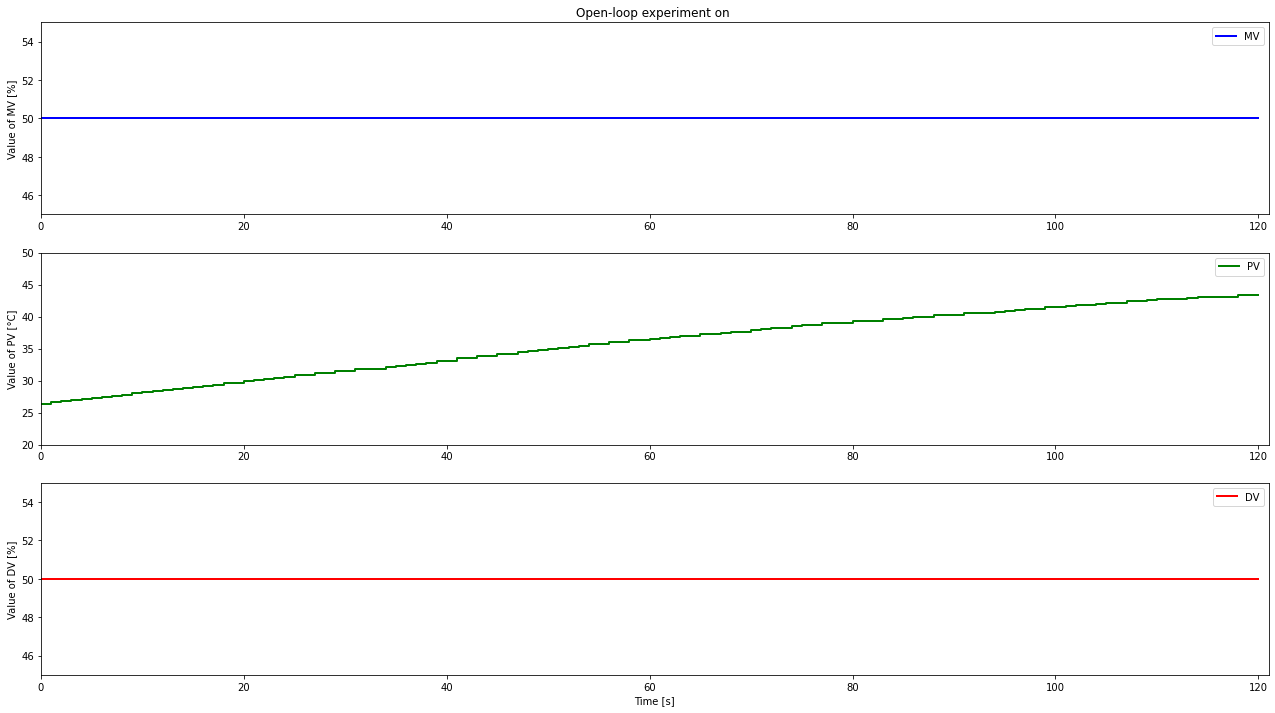

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_figheight(12)
fig.set_figwidth(22)

l1, = ax1.step([0, 1], [0, 100], 'b-', linewidth=2, label='MV', where='post')
ax1.set_ylabel('Value of MV [%]')
ax1.set_title('Open-loop experiment on ')
ax1.legend(loc='best')

l2, = ax2.step([0, 1], [0, 100], 'g-', linewidth=2, label='PV', where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')

l3, = ax3.step([0, 1], [0, 100], 'r-', linewidth=2, label='DV', where='post')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Value of DV [%]')
ax3.legend(loc='best')

lab = tclab.TCLab()
experiment(MV0, DV0, Ts)

## PID + FF Live